# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Homework 6: Trees, Bagging, Random Forests, and Boosting


**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader and Chris Tanner

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

</span></div><div class='alert alert-block alert-danger'><b>WARNING!:</b><span style = 'color:black'> Do not delete any of the `### cs109Test() ###` comment lines!</span></div></div>

</span></div><div class='alert alert-block alert-danger'><b>Note:</b><span style = 'color:black'> Make sure your submission passes all assert statements we've provided in this notebook.</span></div></div>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

# Higgs Boson Discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. 

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background).

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: [Baldi et al., Nature Communications 5, 2014](https://www.nature.com/articles/ncomms5308).

In [3]:
# Load data
data_train = pd.read_csv('data/Higgs_train.csv')
data_test = pd.read_csv('data/Higgs_test.csv')

print(f"{len(data_train)} training samples, {len(data_test)} test samples")
print("\nColumns:")
print(', '.join(data_train.columns))

5000 training samples, 5000 test samples

Columns:
lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb, class


In [4]:
display(data_train.head())
display(data_train.describe())

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080,1.0
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938,1.0
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917,1.0
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954,1.0
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957,0.0


,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.978645,-0.014280,-0.018956,1.005793,0.002528,0.980390,0.025014,-0.007104,0.993678,0.988659,-0.010310,-0.006926,1.006922,0.997004,0.018817,0.003952,1.011994,0.982806,0.005201,0.003349,1.007810,1.038431,1.027201,1.054719,1.023094,0.958464,1.033432,0.960494,0.524600
std,0.547025,1.011927,0.997945,0.591907,1.003337,0.463677,1.002018,1.014559,1.028920,0.476462,1.007983,1.002177,1.045206,0.471681,1.007824,0.999656,1.200416,0.497681,1.007999,1.008904,1.400846,0.619460,0.353984,0.173243,0.427141,0.495720,0.352966,0.306057,0.499444
min,0.275000,-2.410000,-1.740000,0.010000,-1.740000,0.170000,-2.920000,-1.740000,0.000000,0.198000,-2.910000,-1.740000,0.000000,0.265000,-2.720000,-1.740000,0.000000,0.366000,-2.500000,-1.740000,0.000000,0.151000,0.443000,0.339000,0.371000,0.079500,0.413000,0.452000,0.000000
25%,0.587000,-0.764250,-0.877500,0.581000,-0.870000,0.676000,-0.659250,-0.885000,0.000000,0.666000,-0.699000,-0.859500,0.000000,0.664750,-0.679250,-0.858000,0.000000,0.619000,-0.707250,-0.869250,0.000000,0.798750,0.850000,0.986000,0.768000,0.672000,0.826000,0.772750,0.000000
50%,0.846000,-0.009305,-0.016050,0.903500,0.001300,0.891000,0.049500,-0.023500,1.090000,0.891000,-0.004800,-0.030700,1.110000,0.899500,0.045700,0.018800,0.000000,0.877000,0.012900,-0.004700,0.000000,0.898000,0.957000,0.990000,0.922000,0.868000,0.952000,0.877500,1.000000
75%,1.220000,0.725500,0.837000,1.300000,0.866000,1.160000,0.716000,0.894000,2.170000,1.192500,0.692250,0.855500,2.210000,1.232500,0.717000,0.855000,2.550000,1.220000,0.719000,0.859000,3.100000,1.030000,1.090000,1.030000,1.160000,1.120000,1.140000,1.060000,1.000000
max,5.330000,2.430000,1.740000,6.260000,1.740000,4.190000,2.960000,1.740000,2.170000,4.800000,2.910000,1.740000,2.210000,4.630000,2.730000,1.740000,2.550000,5.770000,2.490000,1.740000,3.100000,10.600000,5.740000,3.940000,6.220000,5.080000,4.320000,3.500000,1.000000


In [5]:
# Split into NumPy arrays
X_train = data_train.iloc[:, data_train.columns != 'class'].values
y_train = data_train['class'].values
X_test = data_test.iloc[:, data_test.columns != 'class'].values
y_test = data_test['class'].values

<div class='exercise'><b>Question 1 [20pts]: A Single Model </b></div>
We start by fitting a basic model we can compare the other models to. We will pick a decision tree as the base model because we will later include bagging, random forests and boosting and want a fair comparison. We will tune the decision tree using cross-validation (of course). We will be tuning the maximum tree depth; we refer to this parameter as "depth" for simplicity.

Since we will only be using tree-based methods in this homework, we do not need to standardize or normalize the predictors.


**1.1** Fit a decision tree model to the training set. Choose a range of tree depths from 1 to 20 and evaluate the  performance and standard deviations for each depth using 5-fold cross-validation. Plot the estimated mean +/- 2 standard deviations for each depth. Also, include the training set performance in your plot, but set the y-axis to focus on the cross-validation performance. 
Store the CV means and std variables `cvmeans`, `cvstds` and the train score `train_scores`  

*Hint*: use `plt.fill_between` to shade the region.

**1.2** Select an appropriate depth and justify your choice using your cross-validation estimates. Then report the classification accuracy on the **test set**. Store the training and test accuracies in variables named `best_cv_tree_train_score` and `best_cv_tree_test_score` to refer to in a later question.

**1.3** What is the mechanism by which limiting the depth of the tree avoids over-fitting? What is one downside of limiting the tree depth? 

## Answers

**1.1** Fit a decision tree model to the training set. Choose a range of tree depths from 1 to 20 and evaluate the  performance and standard deviations for each depth using 5-fold cross-validation. Plot the estimated mean +/- 2 standard deviations for each depth. Also, include the training set performance in your plot, but set the y-axis to focus on the cross-validation performance.
Store the CV means and std variables `cvmeans`, `cvstds` and the train score `train_scores`

*Hint*: use `plt.fill_between` to shade the region.


</span></div><div class='alert alert-block alert-danger'><b>WARNING!:</b><span style = 'color:black'> Do not delete any of the `### cs109Test() ###` comment lines!</span></div></div>

In [6]:
### cs109Test(test_1.1a) ###

depths = list(range(1, 21))

def calc_meanstd(X_train, y_train, depths):
    # following section 7
    # create empty dictionaries(?) to store cvmeans, cvstds, and train_scores
    cvmeans = {}
    cvstds = {}
    train_scores = {}
    
    for i in depths:
        # define the model
        model = DecisionTreeClassifier(max_depth=i)
        model.fit(X_train, y_train)
        cv_score = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5, n_jobs=-1)
        acc_score = accuracy_score(y_train, model.predict(X_train))
        cvmeans[i] = cv_score.mean()
        cvstds[i] = cv_score.std()
        train_scores[i] = acc_score
    # end of your code here
    return cvmeans, cvstds, train_scores


</span></div><div class='alert alert-block alert-danger'><b>WARNING!:</b><span style = 'color:black'> Do not delete any of the `### cs109Test() ###` comment lines!</span></div></div>

In [7]:
### cs109Test(test_1.1b) ###
# name the CV means and std variables cvmeans, cvstds and the train score train_scores  
cvmeans, cvstds, train_scores = calc_meanstd(X_train, y_train, depths)

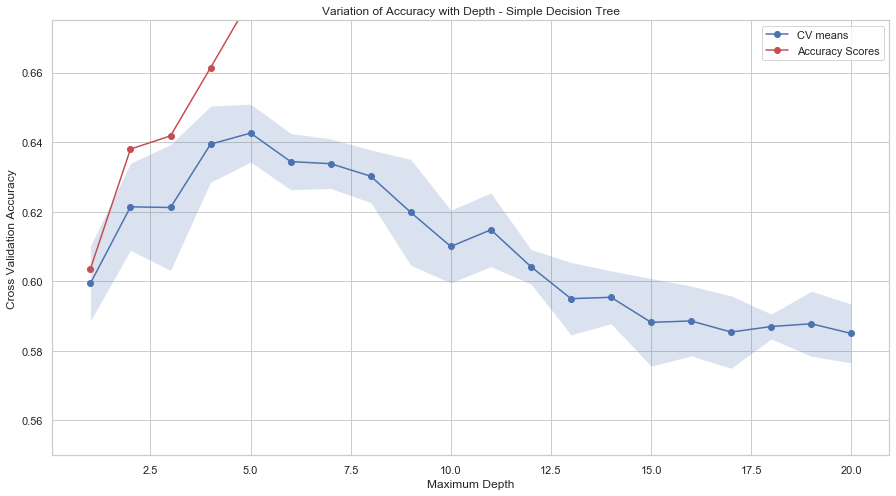

In [8]:
# plot the cvmeans and shade the 2 std region around each
# following section 7

# store sorted keys and values of cvmeans in x and y
lists = sorted(cvmeans.items())
x, y = zip(*lists) 
x,y

# store standard deviations in array
stds = np.array(list(cvstds.values()), dtype=float)

#Plot
fig, ax = plt.subplots(1,1, figsize=(15,8))

# use plt.fill_between to plot stds for each depth
ax.fill_between(x, y + stds, y - stds, alpha=0.2)

ax.set_ylabel("Cross Validation Accuracy")
ax.set_xlabel("Maximum Depth")
ax.set_title('Variation of Accuracy with Depth - Simple Decision Tree')
ax.plot(x, y, 'b-', marker='o', label='CV means')
ax.plot(x, sorted(train_scores.values()), 'r-', marker='o', label='Accuracy Scores');
ax.set_ylim([0.55, 0.675])
ax.legend();
# plt.show()

</span></div><div class='alert alert-block alert-danger'><b>Note:</b><span style = 'color:black'> Make sure your submission passes all assert statements we've provided in this notebook.</span></div></div>

In [9]:
### 1.1 Check that you have the requested variables
for var in ['train_scores', 'cvmeans', 'cvstds']:
    assert var in globals(), f"Variable '{var}' does not exist!"

**1.2** Select an appropriate depth and justify your choice using your cross-validation estimates. Then report the classification accuracy on the **test set**. Store the training and test accuracies in variables named `best_cv_tree_train_score` and `best_cv_tree_test_score` to refer to in a later question.


</span></div><div class='alert alert-block alert-danger'><b>WARNING!:</b><span style = 'color:black'> Do not delete any of the `### cs109Test() ###` comment lines!</span></div></div>

In [10]:
### cs109Test(test_1.3) ###

# create and fit tree model with depth of 5 
best_tree_model = DecisionTreeClassifier(max_depth=5)
best_tree_model.fit(X_train, y_train)

best_cv_tree_train_score = accuracy_score(y_train, best_tree_model.predict(X_train))
best_cv_tree_test_score = accuracy_score(y_test, best_tree_model.predict(X_test))

print("Simple Decision Trees Train Accuracy: {:.2%}".format(best_cv_tree_train_score))
print("Simple Decision Trees Test Accuracy: {:.2%}".format(best_cv_tree_test_score))

Simple Decision Trees Train Accuracy: 68.12%
Simple Decision Trees Test Accuracy: 64.78%


*According to the graph in the previous part, the appropriate depth is 5 with a CV mean score of about 0.64.*

In [11]:
# your code here


In [12]:
### 1.2 Check that you have the requested variables
for var in ['best_cv_tree_train_score', 'best_cv_tree_test_score']:
    assert var in globals(), f"Variable '{var}' does not exist!"

**1.3** What is the mechanism by which limiting the depth of the tree avoids over-fitting? What is one downside of limiting the tree depth?

*Limiting the depth of the tree keeps too many splits from happening. Therefore, the number of resulting nodes is enough that there is no overfitting. It will result in a tree that is not too complex to understand. However, this can lead to low accuracy on the training set.*

<div class='exercise'><b> Question 2 [25 pts]: Bagging </b></div> 
Bagging is the technique of building the same model on multiple bootstrap samples from the data and combining each model's prediction to get an overall classification. In this question we build an example by hand and study how the number of bootstrapped datasets impacts the accuracy of the resulting classification.



**2.1** Using decision trees, choose a tree depth that will overfit the training set. What evidence leads you to believe that this depth  overfits? Assign your choice to a variable named `tree_depth` here. (You may want to explore different settings for this value in the problems below.)

**2.2** Create 55 bootstrapped replications of the original training data, and fit a decision tree to each. Use the tree depth you just chose in 2.1. Record each tree's prediction. In particular, produce a dataset like those shown (see below), where each row is a training and test observation, respectively, each column is one of the trees, and each entry is that tree's prediction for that observation. 

Store these results as `bagging_train_df` and `bagging_test_df`. Don't worry about visualizing these results yet.

**2.3**  _Aggregate_ all 55 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the models predict that example to be from class 1. Assign the bagging accuracy test to a variable name `bagging_accuracy_test`. What accuracy does this *bagging* model achieve on the test set? Write an assertion that verifies that this test-set accuracy is at least as good as the accuracy for the model you fit in Question 1.

**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions` function (given below) to get the model's accuracy score when using only 1,2,3,4,... of the bootstrapped models. Make a plot of training and test set accuracies as a function of number of bootstraps. 
** use the depth that you used above ** 

On your plot, also include horizontal lines for two baselines:
- the test accuracy of the best model from question 1
- the test accuracy of a single tree with the tree depth you chose in 2.1, trained on the full training set.

**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single `tree_depth` tree. Explain the differences you see.

**2.6** Bagging and limiting tree depth both affect how much the model overfits. Compare and contrast these two approaches. Your answer should refer to your graph in 2.4 and may duplicate something you said in your answer to 1.5.

**2.7**: In what ways might our bagging classifier be overfitting the data? In what ways might it be underfitting?

**Hints**
- Use `resample` from sklearn to easily bootstrap the x and y data.
- use `np.mean` to easily test for majority. If a majority of models vote 1, what does that imply about the mean?

## Answers

**2.1** Using decision trees, choose a tree depth that will overfit the training set. What evidence leads you to believe that this depth  overfits? Assign your choice to a variable named `tree_depth` here. (You may want to explore different settings for this value in the problems below.)


</span></div><div class='alert alert-block alert-danger'><b>WARNING!:</b><span style = 'color:black'> Do not delete any of the `### cs109Test() ###` comment lines!</span></div></div>

In [13]:
# cs109Test (test_2.1)
# Assign your choice to a variable named tree_depth
tree_depth = 16

*I will go with 16 because it among the depths that has a high accuracy score on the training set. I also chose it because it has a higher cross validation score compared to 15 and all the numbers after it so it isn't the worst model, it just overfits.*

In [14]:
### 2.1 Check that you have the requested variables
assert 'tree_depth' in globals(), f"Variable 'tree_depth' does not exist!"

**2.2** Create 55 bootstrapped replications of the original training data, and fit a decision tree to each. Use the tree depth you just chose in 2.1. Record each tree's prediction. In particular, produce a dataset like those shown (see below), where each row is a training and test observation, respectively, each column is one of the trees, and each entry is that tree's prediction for that observation.

Store these results as `bagging_train_df` and `bagging_test_df`. Don't worry about visualizing these results yet.


**Structure of `bagging_train_df` and `bagging_test_df`:**

`bagging_train`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 45's prediction|  
| --- | --- | --- | --- | --- |
|training row 1| binary value | binary value|... |binary value|
|training row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |

`bagging_test`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 45's prediction|
| --- | --- | --- | --- | --- |
|test row 1| binary value | binary value|... |binary value|
|test row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |


</span></div><div class='alert alert-block alert-danger'><b>WARNING!:</b><span style = 'color:black'> Do not delete any of the `### cs109Test() ###` comment lines!</span></div></div>

In [15]:
### cs109test(test_2.2) ### 

def bagger(n_trees: int, tree_depth: int,  random_seed=0) -> (pd.DataFrame, pd.DataFrame, list):
    """A function that takes as 
    
    Inputs:
      n_trees
      tree_depth 
      a random_seed (default =0)
    
    Returns:
      bagging_train dataframe (as described above)
      bagging_test dataframe (as described above)
      bagging_models every trained model for each bootstrap (you will need this in Q3.2)
    """
    # following section 7
    # set random seed
    np.random.seed(random_seed)
    
    #Creating model
    bagg_model = DecisionTreeClassifier(max_depth=tree_depth)
    
    #Initializing variables; creating matrices with X rows and n_trees columns
    predictions_train = np.zeros((X_train.shape[0], n_trees))
    predictions_test = np.zeros((X_test.shape[0], n_trees))
    bagging_models = []

    #Conduct bootstraping iterations
    for i in range(n_trees):
        # get bootstrapped sample of indices (with replacement by default)
        index_boot = resample(range(1,len(X_train)))
        temp = X_train[index_boot]
        response_variable = y_train[index_boot]
        
        # fit the model
        bagg_model.fit(temp, response_variable)
        # add columns of predictions
        predictions_train[:,i] = bagg_model.predict(X_train)   
        predictions_test[:,i] = bagg_model.predict(X_test)
        # append re-fit model to list
        bagging_models.append(bagg_model)

    #Make Predictions Dataframe
    columns = ["Bootstrap Model Prediction "+str(i+1) for i in range(n_trees)]
    bagging_train_df = pd.DataFrame(predictions_train, columns=columns)
    bagging_test_df = pd.DataFrame(predictions_test, columns=columns)
    
    return bagging_train_df, bagging_test_df, bagging_models


In [16]:
n_trees = 55 
bagging_train_df, bagging_test_df, bagging_models = bagger(n_trees, tree_depth,  random_seed= 0)
display(bagging_train_df.head())
display(bagging_test_df.head())

,Bootstrap Model Prediction 1,Bootstrap Model Prediction 2,Bootstrap Model Prediction 3,Bootstrap Model Prediction 4,Bootstrap Model Prediction 5,Bootstrap Model Prediction 6,Bootstrap Model Prediction 7,Bootstrap Model Prediction 8,Bootstrap Model Prediction 9,Bootstrap Model Prediction 10,Bootstrap Model Prediction 11,Bootstrap Model Prediction 12,Bootstrap Model Prediction 13,Bootstrap Model Prediction 14,Bootstrap Model Prediction 15,Bootstrap Model Prediction 16,Bootstrap Model Prediction 17,Bootstrap Model Prediction 18,Bootstrap Model Prediction 19,Bootstrap Model Prediction 20,Bootstrap Model Prediction 21,Bootstrap Model Prediction 22,Bootstrap Model Prediction 23,Bootstrap Model Prediction 24,Bootstrap Model Prediction 25,Bootstrap Model Prediction 26,Bootstrap Model Prediction 27,Bootstrap Model Prediction 28,Bootstrap Model Prediction 29,Bootstrap Model Prediction 30,Bootstrap Model Prediction 31,Bootstrap Model Prediction 32,Bootstrap Model Prediction 33,Bootstrap Model Prediction 34,Bootstrap Model Prediction 35,Bootstrap Model Prediction 36,Bootstrap Model Prediction 37,Bootstrap Model Prediction 38,Bootstrap Model Prediction 39,Bootstrap Model Prediction 40,Bootstrap Model Prediction 41,Bootstrap Model Prediction 42,Bootstrap Model Prediction 43,Bootstrap Model Prediction 44,Bootstrap Model Prediction 45,Bootstrap Model Prediction 46,Bootstrap Model Prediction 47,Bootstrap Model Prediction 48,Bootstrap Model Prediction 49,Bootstrap Model Prediction 50,Bootstrap Model Prediction 51,Bootstrap Model Prediction 52,Bootstrap Model Prediction 53,Bootstrap Model Prediction 54,Bootstrap Model Prediction 55
0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,Bootstrap Model Prediction 1,Bootstrap Model Prediction 2,Bootstrap Model Prediction 3,Bootstrap Model Prediction 4,Bootstrap Model Prediction 5,Bootstrap Model Prediction 6,Bootstrap Model Prediction 7,Bootstrap Model Prediction 8,Bootstrap Model Prediction 9,Bootstrap Model Prediction 10,Bootstrap Model Prediction 11,Bootstrap Model Prediction 12,Bootstrap Model Prediction 13,Bootstrap Model Prediction 14,Bootstrap Model Prediction 15,Bootstrap Model Prediction 16,Bootstrap Model Prediction 17,Bootstrap Model Prediction 18,Bootstrap Model Prediction 19,Bootstrap Model Prediction 20,Bootstrap Model Prediction 21,Bootstrap Model Prediction 22,Bootstrap Model Prediction 23,Bootstrap Model Prediction 24,Bootstrap Model Prediction 25,Bootstrap Model Prediction 26,Bootstrap Model Prediction 27,Bootstrap Model Prediction 28,Bootstrap Model Prediction 29,Bootstrap Model Prediction 30,Bootstrap Model Prediction 31,Bootstrap Model Prediction 32,Bootstrap Model Prediction 33,Bootstrap Model Prediction 34,Bootstrap Model Prediction 35,Bootstrap Model Prediction 36,Bootstrap Model Prediction 37,Bootstrap Model Prediction 38,Bootstrap Model Prediction 39,Bootstrap Model Prediction 40,Bootstrap Model Prediction 41,Bootstrap Model Prediction 42,Bootstrap Model Prediction 43,Bootstrap Model Prediction 44,Bootstrap Model Prediction 45,Bootstrap Model Prediction 46,Bootstrap Model Prediction 47,Bootstrap Model Prediction 48,Bootstrap Model Prediction 49,Bootstrap Model Prediction 50,Bootstrap Model Prediction 51,Bootstrap Model Prediction 52,Bootstrap Model Prediction 53,Bootstrap Model Prediction 54,Bootstrap Model Prediction 55
0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


In [17]:
### 2.2 Check that you have the requested function & variables
assert 'bagger' in globals(), f"Function 'bagger()' does not exist!"
for var in ['bagging_train_df', 'bagging_test_df']:
    assert var in globals(), f"Variable '{var}' does not exist!"

**2.3**  _Aggregate_ all 55 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the models predict that example to be from class 1. Assign the bagging accuracy test to a variable name `bagging_accuracy_test`. What accuracy does this *bagging* model achieve on the test set? Write an assertion that verifies that this test-set accuracy is at least as good as the accuracy for the model you fit in Question 1.


</span></div><div class='alert alert-block alert-danger'><b>WARNING!:</b><span style = 'color:black'> Do not delete any of the `### cs109Test() ###` comment lines!</span></div></div>

In [18]:
### cs109test(test_2.3) ### 
# following section 7

#Check Accuracy of Spam Detection in Test Set
# use np.mean(bagging_test_df, axis=1)>0.5 to get all the means that are greater than 0.5 (classify to 1.0)
bagging_accuracy_test  = 100*accuracy_score(y_test, np.mean(bagging_test_df, axis=1)>0.5)

print("Bagging Testing Accuracy: {:0.2f}%".format(bagging_accuracy_test))

Bagging Testing Accuracy: 69.46%


In [19]:
### 2.3 Check that you have the requested variable
assert 'bagging_accuracy_test' in globals(), f"Variable 'bagging_accuracy_test' does not exist!"

**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions` function (given below) to get the model's accuracy score when using only 1,2,3,4,... of the bootstrapped models. Make a plot of training and test set accuracies as a function of number of bootstraps.
**use the depth that you used above**

On your plot, also include horizontal lines for two baselines:
- the test accuracy of the best model from question 1
- the test accuracy of a single tree with the tree depth you chose in 2.1, trained on the full training set.


In [20]:
def running_predictions(prediction_dataset: np.ndarray, targets: np.ndarray) -> np.ndarray:
    """A function to predict examples' class via the majority among trees (ties are predicted as 0)
    
    Inputs:
      prediction_dataset - a (n_examples by n_sub_models) dataset (not a dataframe), where each entry [i,j] is sub-model j's prediction
          for example i
      targets - the true class labels
    
    Returns:
      a vector where vec[i] is the model's accuracy when using just the first i+1 sub-models
    """
    
    n_trees = prediction_dataset.shape[1]
    
    # find the running percentage of models voting 1 as more models are considered
    running_percent_1s = np.cumsum(prediction_dataset, axis=1)/np.arange(1,n_trees+1)
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    return np.mean(running_correctnesss, axis=0)
    # returns a 1-d series of the accuracy of using the first n trees to predict the targets

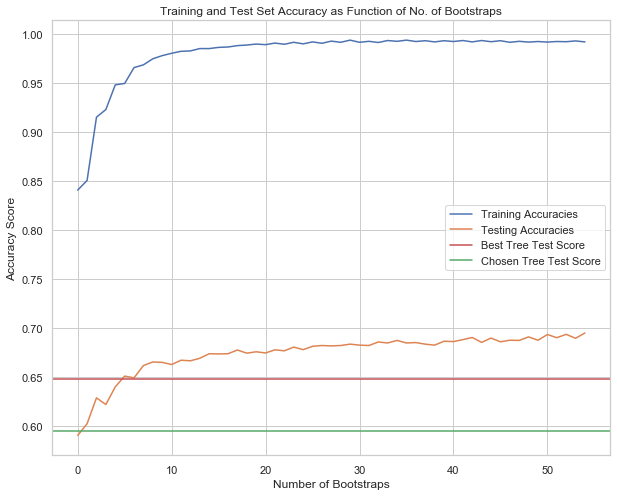

In [21]:
# plotting code
fig, ax = plt.subplots(1,1, figsize = (10,8))

ax.plot(range(0,n_trees), running_predictions(bagging_train_df.values, y_train), label = "Training Accuracies")
ax.plot(range(0,n_trees), running_predictions(bagging_test_df.values, y_test), label = "Testing Accuracies")
ax.set_xlabel("Number of Bootstraps")
ax.set_ylabel("Accuracy Score")
ax.set_title('Training and Test Set Accuracy as Function of No. of Bootstraps')

# horizontal line with test score from best model
ax.axhline(y=best_cv_tree_test_score, color = 'r', label = 'Best Tree Test Score')

# define tree model with tree_depth from 2.1
tree_model = DecisionTreeClassifier(max_depth=tree_depth)
tree_model.fit(X_train, y_train)
# score the model
tree_test_score = accuracy_score(y_test, tree_model.predict(X_test))

# horizontal line with test score from chosen tree depth
ax.axhline(y=tree_test_score, color = 'g', label = 'Chosen Tree Test Score')

ax.legend();

In [22]:
### 2.4 Check that you have the requested function
assert 'running_predictions' in globals(), f"Function 'running_predictions()' does not exist!"

**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single `tree_depth` tree. Explain the differences you see.


*According to the graph, it appears that bagging is much more accurate than the chosen single tree model. As the number of bootstraps increases, the accuracy on the test set is much higher - nearly a difference of 10\%.*

**2.6** Bagging and limiting tree depth both affect how much the model overfits. Compare and contrast these two approaches. Your answer should refer to your graph in 2.4 and may duplicate something you said in your answer to 1.5.


*Bagging and limiting tree depth are different in that bagging works to improve on complex trees whereas limiting tree depth works to prevent trees from becoming too complex. They are similar in that they are attempting to reduce the variance of the predictions.*

**2.7**: In what ways might our bagging classifier be overfitting the data? In what ways might it be underfitting?

**Hints**
- Use `resample` from sklearn to easily bootstrap the x and y data.
- use `np.mean` to easily test for majority. If a majority of models vote 1, what does that imply about the mean?

*The bagging classifier may be overfitting the data because it could be working with trees that are still too complex. In the same vein, it could be underfitting if the trees being used are too simple.*

<div class='exercise'> <b> Question 3 [20 pts]: Random Forests </b> </div>
Random Forests are closely related to the bagging model we built by hand in question 2. In this question we compare our by-hand results with the results of using `RandomForestClassifier` directly.






**3.1**  Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees that you used in Question 2.2. Use number of features to consider when looking for the best split to be the `sqrt(total_number of features`. Evaluate its accuracy on the test set and assign it to a variable name `random_forest_test_score`.

**3.2** Among all of the decision trees you fit in the bagging process, how many times is each feature used as the top/first node? How about for each tree in the random forest you just fit? What about the process of training the Random Forest causes this difference? What implication does this observation have on the accuracy of bagging vs Random Forest?
Assign this to two pandas Series called `top_predictors_bagging` and `top_predictors_rf` and give them an example] 

**Hint**: A decision tree's top feature is stored in `model.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.


**3.3**: Make a pandas table of the training and test accuracy for the following models and name it `results_df`:

- Single tree with best depth chosen by cross-validation (from Question 1)
- A single overfit tree trained on all data (from Question 2, using the depth you chose there)
- Bagging 55 such trees (from Question 2)
- A Random Forest of 55 such trees (from Question 3.1)

(see below for the expected structure)  

(This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.)

What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance trade-off.

## Answers

**3.1**  Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees that you used in Question 2.2. Use number of features to consider when looking for the best split to be the `sqrt(total_number of features`. Evaluate its accuracy on the test set and assign it to a variable name `random_forest_test_score`.


</span></div><div class='alert alert-block alert-danger'><b>WARNING!:</b><span style = 'color:black'> Do not delete any of the `### cs109Test() ###` comment lines!</span></div></div>

In [23]:
np.sqrt(X_train.shape[1]).astype(int)  # DELETE

5

In [24]:
### cs109test(test_3.1) ### 
# following section 7 again

# Train and fit random forest model
# using square root and forcing into an int as n_estimators
rand_model = RandomForestClassifier(n_estimators=n_trees, max_features = np.sqrt(X_train.shape[1]).astype(int), 
                                    max_depth=tree_depth)
rand_model.fit(X_train, y_train)

#Predict
y_pred_rand_test = rand_model.predict(X_test)

#Accuracy on test set
random_forest_test_score = accuracy_score(y_test, y_pred_rand_test)*100

print("Random Forest Testing Accuracy:  {:0.2f}%".format(random_forest_test_score))

Random Forest Testing Accuracy:  68.84%


In [25]:
### 3.1 Check that you have the requested variable
assert 'random_forest_test_score' in globals(), f"Variable 'random_forest_test_score' does not exist!"

**3.2** Among all of the decision trees you fit in the bagging process, how many times is each feature used as the top/first node? How about for each tree in the random forest you just fit? What about the process of training the Random Forest causes this difference? What implication does this observation have on the accuracy of bagging vs Random Forest?
Assign this to two pandas Series called `top_predictors_bagging` and `top_predictors_rf`.

**Hint**: A decision tree's top feature is stored in `model.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.



</span></div><div class='alert alert-block alert-danger'><b>WARNING!:</b><span style = 'color:black'> Do not delete any of the `### cs109Test() ###` comment lines!</span></div></div>

In [26]:
cur_index = bagging_models[3].tree_.feature[0]
data_train.columns[cur_index]

'm_bb'

In [27]:
### cs109test(test_3.2) ### 

# create bagg dictionary where the keys are the names of the columns
bagg_dict = dict.fromkeys(data_train.columns, 0)
# create random dictionary where the keys are the names of the columns
rand_dict = dict.fromkeys(data_train.columns, 0)

# do a for loop to loop through each model
for i in range(n_trees):
    # store index of top features in respective index variables
    bagg_index = bagging_models[i].tree_.feature[0]  # index of top feature in ith bagging model
    rand_index = rand_model.estimators_[i].tree_.feature[0]  # index of top feature in ith random forest model
    
    # index into data_train.columns - store name of feature
    bfeature = data_train.columns[bagg_index]
    rfeature = data_train.columns[rand_index]
    
    # loop through keys in both dictionaries - can do keys from 1 dictionary bc same keys
    for j in bagg_dict.keys():
        # if current bagg top feature is current key, add 1
        if bfeature == j:
            bagg_dict[j] = bagg_dict[j]+1
        # if current rand top feature is current key, add 1
        if rfeature == j:
            rand_dict[j] = rand_dict[j]+1

# create pandas series
top_predictors_bagging = pd.Series(bagg_dict)
top_predictors_rf = pd.Series(rand_dict)

display(top_predictors_bagging)
display(top_predictors_rf)

lepton pT                    0
lepton eta                   0
lepton phi                   0
missing energy magnitude     0
missing energy phi           0
jet 1 pt                     0
jet 1 eta                    0
jet 1 phi                    0
jet 1 b-tag                  0
jet 2 pt                     0
jet 2 eta                    0
jet 2 phi                    0
jet 2 b-tag                  0
jet 3 pt                     0
jet 3 eta                    0
jet 3 phi                    0
jet 3 b-tag                  0
jet 4 pt                     0
jet 4 eta                    0
jet 4 phi                    0
jet 4 b-tag                  0
m_jj                         0
m_jjj                        0
m_lv                         0
m_jlv                        0
m_bb                        55
m_wbb                        0
m_wwbb                       0
class                        0
dtype: int64

lepton pT                    2
lepton eta                   0
lepton phi                   0
missing energy magnitude     5
missing energy phi           0
jet 1 pt                     3
jet 1 eta                    2
jet 1 phi                    0
jet 1 b-tag                  0
jet 2 pt                     2
jet 2 eta                    2
jet 2 phi                    0
jet 2 b-tag                  2
jet 3 pt                     0
jet 3 eta                    1
jet 3 phi                    0
jet 3 b-tag                  0
jet 4 pt                     0
jet 4 eta                    0
jet 4 phi                    0
jet 4 b-tag                  0
m_jj                         1
m_jjj                        5
m_lv                         0
m_jlv                        1
m_bb                         6
m_wbb                       11
m_wwbb                      12
class                        0
dtype: int64

*It would appear that the bagging method used the same feature, `m_bb`, as the same top feature for every tree. The random forest method used different features as top features. This could mean that the bagging model is more accurate but not necessarily correct.*

In [28]:
### 3.2 Check that you have the requested variables
for var in ['top_predictors_bagging', 'top_predictors_rf']:
    assert var in globals(), f"Variable '{var}' does not exist!"

**3.3**: Make a pandas table of the training and test accuracy for the following models and name it `results_df`:

- Single tree with best depth chosen by cross-validation (from Question 1)
- A single overfit tree trained on all data (from Question 2, using the depth you chose there)
- Bagging 55 such trees (from Question 2)
- A Random Forest of 55 such trees (from Question 3.1)

(see below for the expected structure)

(This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.)

What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance trade-off.

Fill in the following table.


| classifier | training accuracy | test accuracy |
| --- | --- | --- |
| single tree with best depth chosen by CV | | |
| single depth-X tree | | |
| bagging 55 depth-X trees | | |
| Random Forest of 55 depth-X trees | | |

In [29]:
# gathering all entries
# single tree with best depth chosen by CV - multiplying by 100 because I didn't before
best_cv_tree_train_score2 = 100*best_cv_tree_train_score
best_cv_tree_test_score2 = 100*best_cv_tree_test_score

# single depth-X tree - multiplying by 100 because I didn't before
# tree_model is the single decision tree model with my chosen depth
tree_test_score2 = 100*tree_test_score
tree_train_score2 = 100*accuracy_score(y_train, tree_model.predict(X_train))

# bagging 55 depth-X trees
bagging_accuracy_test2 = bagging_accuracy_test
bagging_accuracy_train2 = 100*accuracy_score(y_train, np.mean(bagging_train_df, axis=1)>0.5)

# random Forest of 55 depth-X trees
random_forest_test_score2 = random_forest_test_score
random_forest_train_score2 = 100*accuracy_score(y_train, rand_model.predict(X_train))

# create entries for creating dataframe
values = [[best_cv_tree_test_score2, best_cv_tree_train_score2],
          [tree_train_score2, tree_test_score2],
          [bagging_accuracy_train2, bagging_accuracy_test2],
          [random_forest_train_score2, random_forest_test_score2]]

columns = ['training accuracy', 'test accuracy']
index = ['single tree with best depth chosen by CV', 'single depth-X tree', 'bagging 55 depth-X trees', 
         'Random Forest of 55 depth-X trees']
index_name = 'classifier'

# create the dataframe
results_df = pd.DataFrame(values, index = index, columns = columns)
results_df

,training accuracy,test accuracy
single tree with best depth chosen by CV,64.78,68.12
single depth-X tree,99.04,59.48
bagging 55 depth-X trees,99.16,69.46
Random Forest of 55 depth-X trees,99.90,68.84


*Each model gets increasingly more accurate with each subsequent model. The best CV decision tree model has a higher accuracy score than the decision tree model with different depth on the test set. The subsequent bagging and random forest models have higher accuracy on the test set. These relationships make sense given that each subsequent model reduces variance and therefore become more accurate. It also makes sense that it works very well on the training set and not so well on the test set. This could be because these models are actually doing well at not overfitting.*

In [30]:
### 3.3 Check that you have the requested variable
assert 'results_df' in globals(), "Variable 'results_df' does not exist!"

<div class='exercise'><b> Question 4 [15 pts]: Boosting </div>
In this question we explore a different kind of ensemble method, boosting, where each new model is trained on a dataset weighted towards observations that the current set of models predicts incorrectly. 

We'll focus on the AdaBoost flavor of boosting and examine what happens to the ensemble model's accuracy as the algorithm adds more estimators (iterations) to the ensemble.

**4.1** We'll motivate AdaBoost by noticing patterns in the errors that a single classifier makes. Fit `tree1`, a decision tree with depth 3, to the training data. 
Report the train and test accuracies. For each predictor, make a plot that compares two distributions: the values of that predictor for examples that `tree1` classifies correctly, and the values of that predictor for examples that `tree1` classifies incorrectly. Do you notice any predictors for which the distributions are clearly different?

*Hints*:
- If you have `fig, axs = plt.subplots(...)`, then `axs.ravel()` gives a list of each plot in reading order.
- [`sns.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) takes `ax` and `label` parameters.

**4.2** The following code (see below) attempts to implement a simplified version of boosting using just two classifiers (described below). However, it has both stylistic and functionality flaws. First, imagine that you are a grader for a Data Science class; write a comment for the student who submitted this code. Then, imagine that you're the TF writing the solutions; make an excellent example implementation. Finally, use your corrected code to compare the performance of `tree1` and the boosted algorithm on both the training and test set.

**4.3** Now let's use the sklearn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 800 iterations. Make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

*Hint*: The `staged_score` method provides the accuracy numbers you'll need. You'll need to use `list()` to convert the "generator" it returns into an ordinary list.

**4.4** Repeat the plot above for a base learner with depth of (1, 2, 3, 4). What trends do you see in the training and test accuracy?

(It's okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.)

**4.5** Based on the plot you just made, what combination of base learner depth and number of iterations seems optimal? Why? How does the performance of this model compare with the performance of the ensembles you considered above?

## Answers

**4.1** We'll motivate AdaBoost by noticing patterns in the errors that a single classifier makes. Fit `tree1`, a decision tree with depth 3, to the training data.
Report the train and test accuracies. For each predictor, make a plot that compares two distributions: the values of that predictor for examples that `tree1` classifies correctly, and the values of that predictor for examples that `tree1` classifies incorrectly. Do you notice any predictors for which the distributions are clearly different?

*Hints*:
- If you have `fig, axs = plt.subplots(...)`, then `axs.ravel()` gives a list of each plot in reading order.
- [`sns.kdeplot`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) takes `ax` and `label` parameters.


In [31]:
# create and fit tree model with depth of 3 
tree1 = DecisionTreeClassifier(max_depth=3)
tree1.fit(X_train, y_train)

# Predict (for plotting)
y_train_tree1_pred = tree1.predict(X_train)

# Score
tree1_train_score = accuracy_score(y_train, y_train_tree1_pred)
tree1_test_score = accuracy_score(y_test, tree1.predict(X_test))

# Report
print("Tree1 Train Accuracy: {:.2%}".format(tree1_train_score))
print("Tree1 Test Accuracy: {:.2%}".format(tree1_test_score))

Tree1 Train Accuracy: 64.18%
Tree1 Test Accuracy: 64.42%


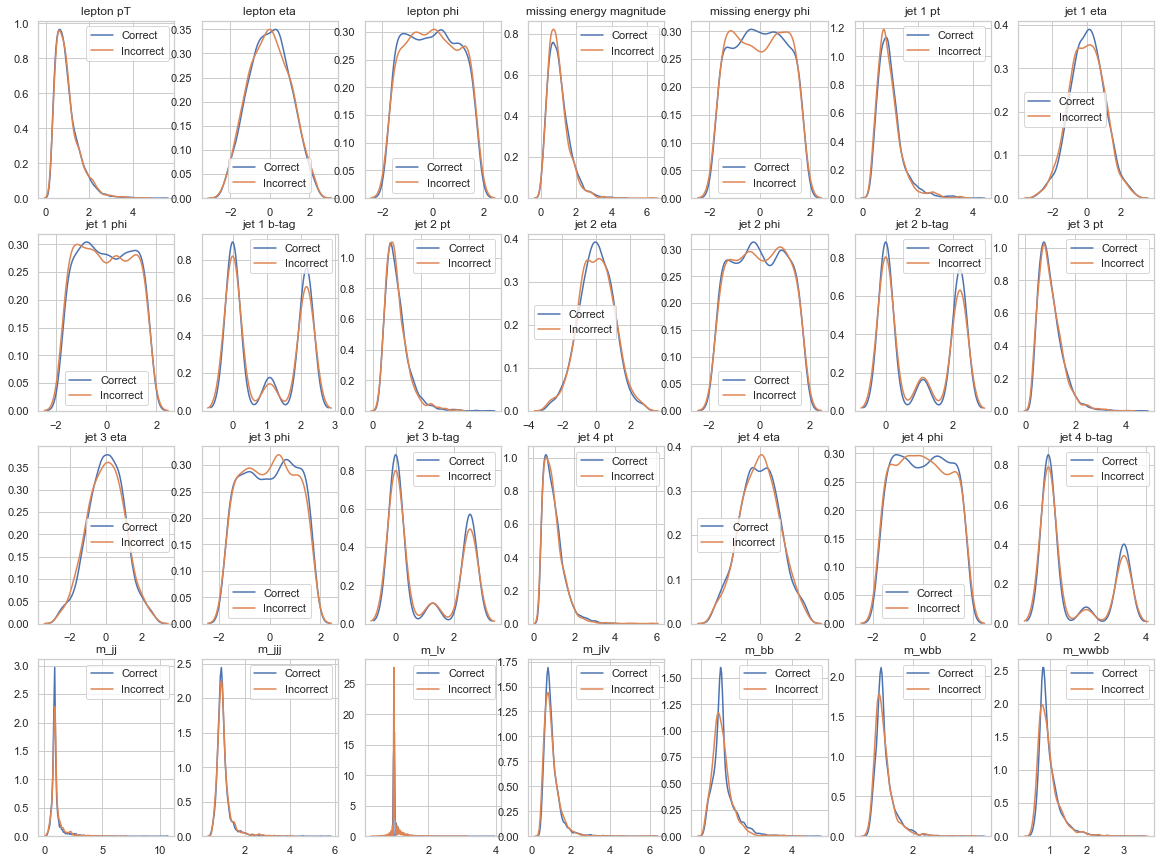

In [32]:
# Plotting
# figure out how to plot what tree1 got right for each predictor
fig, axs = plt.subplots(4, 7, figsize = (20,15))
axs = axs.ravel()

# for loop through each column of X_train (same for X_test)
for feature in range(X_train.shape[1]):
    # plot correct predictions distribution
    sns.kdeplot(X_train[:,feature][y_train_tree1_pred == y_train], ax = axs[feature], label='Correct')
    
    # plot incorrect predictions distribution
    sns.kdeplot(X_train[:,feature][y_train_tree1_pred != y_train], ax = axs[feature], label='Incorrect')
    
    axs[feature].set_title(data_train.columns[feature])

*It looks like `lepton phi`, `missing energy phi`, `jet 1 phi`, and `jet 4 phi` have very different distributions between the correct predictions and the incorrect predictions.*

In [33]:
### 4.1 Check that you have the requested variable
assert 'tree1' in globals(), "Variable 'tree1' does not exist!"

**4.2** The following code (see below) attempts to implement a simplified version of boosting using just two classifiers (described below). However, it has both stylistic and functionality flaws. First, imagine that you are a grader for a Data Science class; write a comment for the student who submitted this code. Then, imagine that you're the TF writing the solutions; make an excellent example implementation. Finally, use your corrected code to compare the performance of `tree1` and the boosted algorithm on both the training and test set.


The intended functionality is the following:
1. Fit `tree1`, a decision tree with max depth 3.
2. Construct an array of sample weights. Give a weight of 1 to samples that `tree1` classified correctly, and 2 to samples that `tree1` misclassified.
3. Fit `tree2`, another depth-3 decision tree, using those sample weights.
4. To predict, compute the probabilities that `tree1` and `tree2` each assign to the positive class. Take the average of those two probabilities as the prediction probability.

In [34]:
def boostmeup(X, y):
    tree = DecisionTreeClassifier(max_depth=3)
    tree1 = tree.fit(X, y)
    sample_weight = np.ones(len(X_train))
    q = 0
    for idx in range(len(X_train)):
          if tree1.predict([X_train[idx]]) != y_train[idx]:
             sample_weight[idx] = sample_weight[idx] * 2
             q = q + 1
    print("tree1 accuracy:", q / len(X_train))
    tree2 = tree.fit(X_train, y_train, sample_weight=sample_weight)
    
# Train
    q = 0
    for idx in range(len(X_train)):
        t1p = tree1.predict_proba([X_train[idx]])[0][1]
        t2p = tree2.predict_proba([X_train[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_train))

# Test
    q = 0
    for idx in range(len(X_test)):
        t1p = tree1.predict_proba([X_test[idx]])[0][1]
        t2p = tree2.predict_proba([X_test[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_test))

boostmeup(X_train, y_train)

tree1 accuracy: 0.3582
Boosted accuracy: 0.0008
Boosted accuracy: 0.002


*Your answer here*

In [35]:
# your code here


In [37]:
### 4.2 Check that you have the requested variables
for var in ['tree1', 'tree2']:
    assert var in globals(), f"Variable '{var}' does not exist!"

AssertionError: Variable 'tree2' does not exist!

**4.3** Now let's use the sklearn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 800 iterations. Make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

*Hint*: The `staged_score` method provides the accuracy numbers you'll need. You'll need to use `list()` to convert the "generator" it returns into an ordinary list.


In [40]:
# following section 8
# Training
ada_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), 
                           n_estimators=800, 
                           learning_rate=0.05)
ada_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

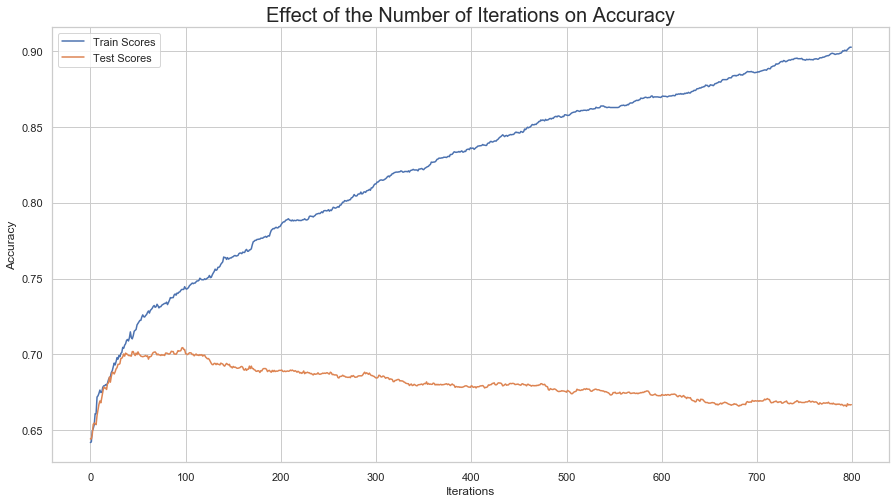

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))

ax.set_xlabel('Iterations')
ax.set_ylabel('Accuracy')
ax.set_title('Effect of the Number of Iterations on Accuracy', fontsize = 20)
ax.plot(list(ada_model.staged_score(X_train, y_train)), label = 'Train Scores')
ax.plot(list(ada_model.staged_score(X_test, y_test)), label = 'Test Scores')
ax.legend();

**4.4** Repeat the plot above for a base learner with depth of (1, 2, 3, 4). What trends do you see in the training and test accuracy?

(It's okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.)


In [42]:
# fit models for other base learners
adaboost_models = []

for i in [1, 2, 3, 4]:
    ada_model_i = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=i), 
                           n_estimators=800, 
                           learning_rate=0.05)
    ada_model_i.fit(X_train, y_train)
    adaboost_models.append(ada_model_i)

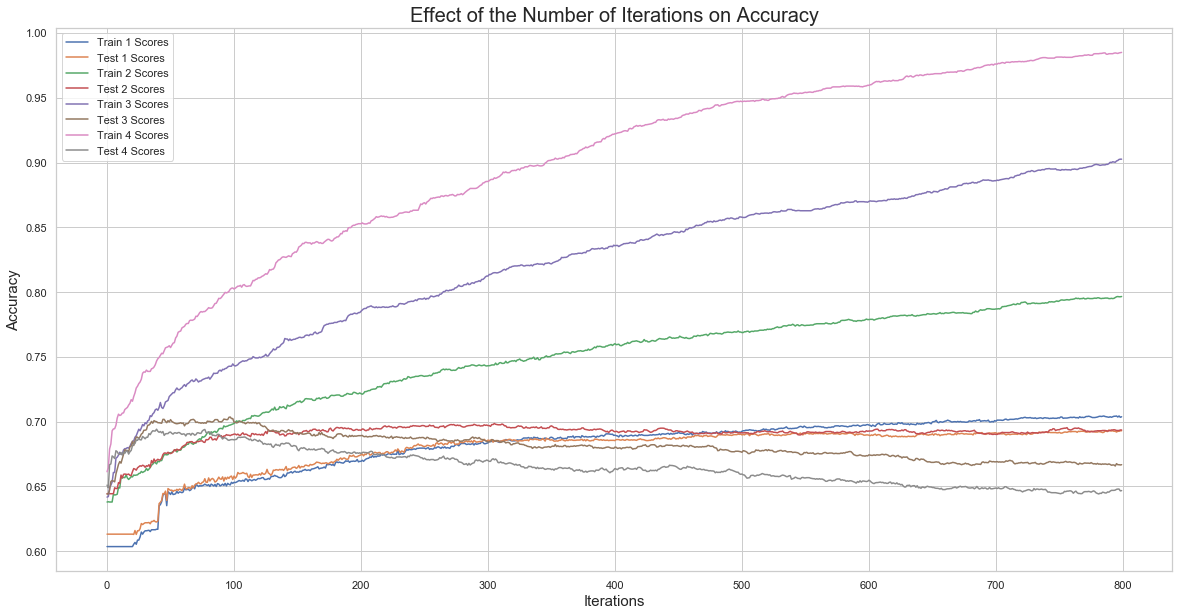

In [43]:
# plotting each model
fig, ax = plt.subplots(1, 1, figsize=(20,10))

ax.set_xlabel('Iterations', fontsize = 15)
ax.set_ylabel('Accuracy', fontsize = 15)
ax.set_title('Effect of the Number of Iterations on Accuracy', fontsize = 20)

# iterate through models
for model in [0, 1, 2, 3]:
    ax.plot(list(adaboost_models[model].staged_score(X_train, y_train)), label = 'Train {} Scores'.format(model+1))
    ax.plot(list(adaboost_models[model].staged_score(X_test, y_test)), label = 'Test {} Scores'.format(model+1))
    ax.legend();

*With more depth, there is more accuracy on the training set overall. The opposite seems to be true on test set, especially with greater number of iterations. Also, the difference in accuracy between the test and training data grows as the tree depth and iterations grow.*

**4.5** Based on the plot you just made, what combination of base learner depth and number of iterations seems optimal? Why? How does the performance of this model compare with the performance of the ensembles you considered above?

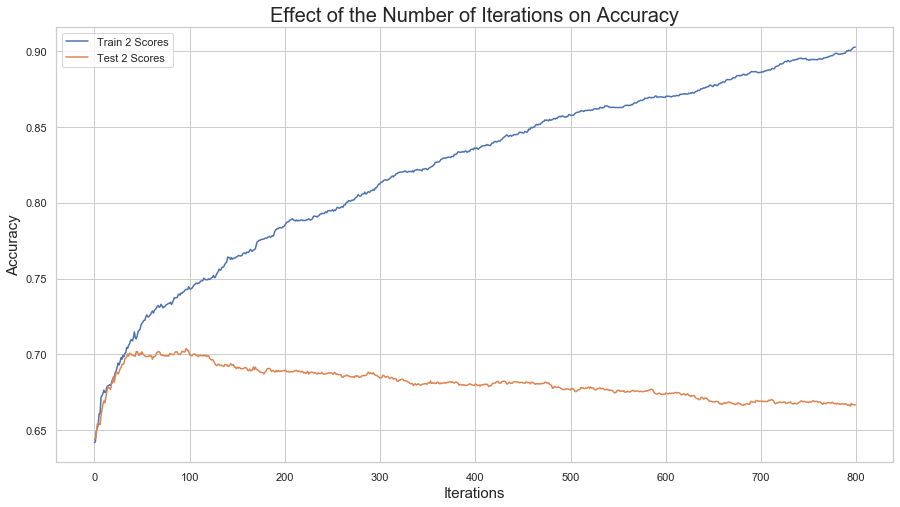

In [44]:
# recreating ideal model
fig, ax = plt.subplots(1, 1, figsize=(15,8))

ax.set_xlabel('Iterations', fontsize = 15)
ax.set_ylabel('Accuracy', fontsize = 15)
ax.set_title('Effect of the Number of Iterations on Accuracy', fontsize = 20)

ax.plot(list(adaboost_models[2].staged_score(X_train, y_train)), label = 'Train 2 Scores')
ax.plot(list(adaboost_models[2].staged_score(X_test, y_test)), label = 'Test 2 Scores')
ax.legend();

*It seems that a tree depth of 3 with about 40 iterations is the ideal combination. There are similar accuracies on the train and test data without fear of overfitting and it is higher than the other tree depths were at this number of iterations.*

<div class='exercise'> <b> Question 5 [15 pts]: Understanding </b></div>
This question is an overall test of your knowledge of this homework's material. You may need to refer to lecture notes and other material outside this homework to answer these questions.



**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?


**5.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?

**5.3** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

**5.4** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

**5.5** Which of these techniques can be extended to regression tasks? How?


## Answers

**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?



*Bagging and boosting are related because they do many iterations on the predictors of the dataset and build many new models. They are different because bagging works to decrease variance by taking random samples of the predictors, building independent models, and aggregating them. Boosting builds models based on the performance of the previous one and works to reduce bias.* 

**5.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?


*Between bagging and boosting which performed the best on the test sets, it would appear that boosting ultimately performed best. It was the one classifer that had a combination of iterations and tree depth that had high performance on the test set. This can be seen at about 100 predictors in the graph in 4.5.*

**5.3** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?


*If there are too many trees in boosting and bagging, they perform worse. It is worse to have too many trees when boosting because it already prone to overfitting and will easily do so if there are more trees than necessary.*

**5.4** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?


*It is likely that bagging is better suited to parallelization because it is inherently built in such a way that many models are created independently then aggregated. It wouldn't make as much sense with boosting since it is performed by building models sequentially.*

**5.5** Which of these techniques can be extended to regression tasks? How?

*Both techniques can be extended to regression tasks. With bagging, the outputs of the different regression models can be averaged to get the result. With boosting, the methods used in classifiying can easily be extended to creating regression lines. The different weights could influence the new shapes of the prediction lines.*